In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 1-6 terasort.txt to 1-6 terasort.txt
Saving 1-5 terasort (1).txt to 1-5 terasort (1).txt
Saving 1-4 terasort (1).txt to 1-4 terasort (1).txt
Saving 1-3 terasort (1).txt to 1-3 terasort (1).txt
Saving 1-2 terasort (1).txt to 1-2 terasort (1).txt
Saving 1-1 terasort (1).txt to 1-1 terasort (1).txt


In [4]:
spark_files = [
    '1-1 terasort (1).txt',
    '1-2 terasort (1).txt',
    '1-3 terasort (1).txt',
    '1-4 terasort (1).txt',
    '1-5 terasort (1).txt',
    '1-6 terasort.txt'
]

In [7]:
# Parsing Spark TeraSort Log
def parse_spark_terasort_log(file_path):
    metrics = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'Wall Time:' in line:
            metrics['wall_time'] = float(re.findall(r"[-+]?[.]?\d+\.?\d*", line)[0])
        if 'Shuffle Throughput:' in line:
            metrics['shuffle_throughput'] = float(re.findall(r"[-+]?[.]?\d+\.?\d*", line)[0])
        if 'Memory Utilization per Worker:' in line:
            metrics['mem_util'] = float(re.findall(r"[-+]?[.]?\d+\.?\d*", line)[0])
        if 'HDFS I/O Throughput per Worker:' in line:
            metrics['io_throughput'] = float(re.findall(r"[-+]?[.]?\d+\.?\d*", line)[0])
        if 'Aggregate Resource Utilization:' in line:
            metrics['agg_resource_util'] = float(re.findall(r"[-+]?[.]?\d+\.?\d*", line)[0])

    return metrics

In [8]:
# Extracting Metrics into DataFrame
spark_results = []

for file in spark_files:
    result = parse_spark_terasort_log(file)
    workers = int(re.findall(r'1-(\d+)', file)[0])
    result['num_workers'] = workers
    spark_results.append(result)

spark_df = pd.DataFrame(spark_results)
spark_df = spark_df.sort_values('num_workers')
spark_df

,wall_time,shuffle_throughput,agg_resource_util,mem_util,io_throughput,num_workers
0,36.15,4.12,36146.55,1024.0,4.12,1
1,36.99,4.03,73980.10,1024.0,2.01,2
2,35.65,4.18,106940.60,1024.0,1.39,3
3,38.08,3.91,152314.37,1024.0,0.98,4
4,37.33,3.99,186627.17,1024.0,0.80,5
5,28.54,5.22,171243.98,1024.0,0.87,6


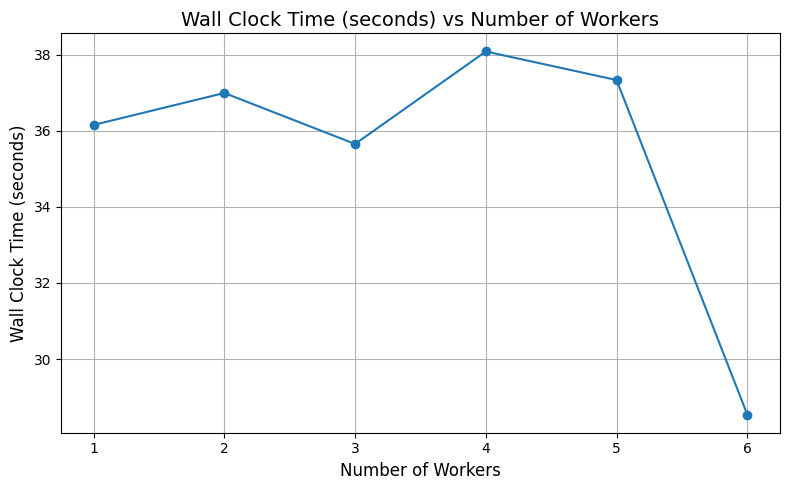

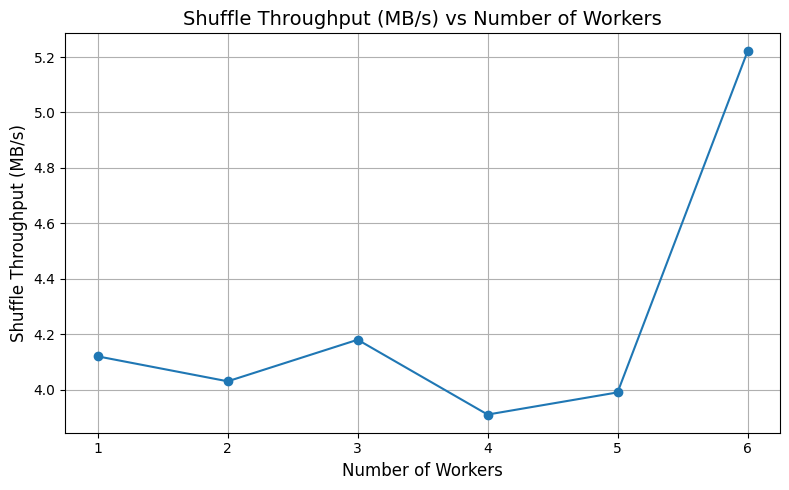

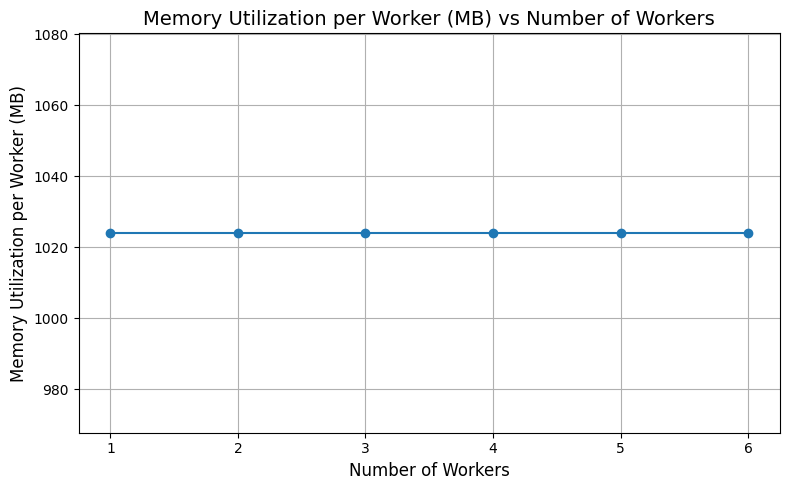

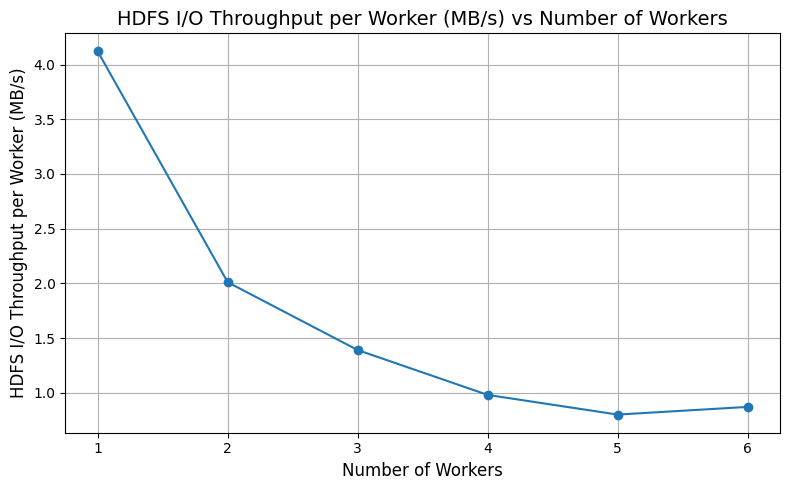

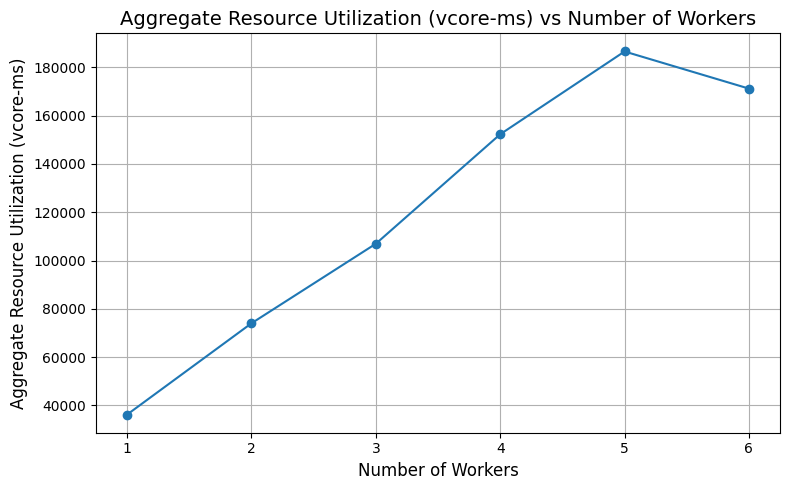

In [9]:
# Individual Metrics

metrics = ['wall_time', 'shuffle_throughput', 'mem_util', 'io_throughput', 'agg_resource_util']
metric_titles = {
    'wall_time': 'Wall Clock Time (seconds)',
    'shuffle_throughput': 'Shuffle Throughput (MB/s)',
    'mem_util': 'Memory Utilization per Worker (MB)',
    'io_throughput': 'HDFS I/O Throughput per Worker (MB/s)',
    'agg_resource_util': 'Aggregate Resource Utilization (vcore-ms)'
}

for metric in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(spark_df['num_workers'], spark_df[metric], marker='o')
    plt.title(f'{metric_titles[metric]} vs Number of Workers', fontsize=14)
    plt.xlabel('Number of Workers', fontsize=12)
    plt.ylabel(metric_titles[metric], fontsize=12)
    plt.grid(True)
    plt.xticks(spark_df['num_workers'])
    plt.tight_layout()
    plt.show()

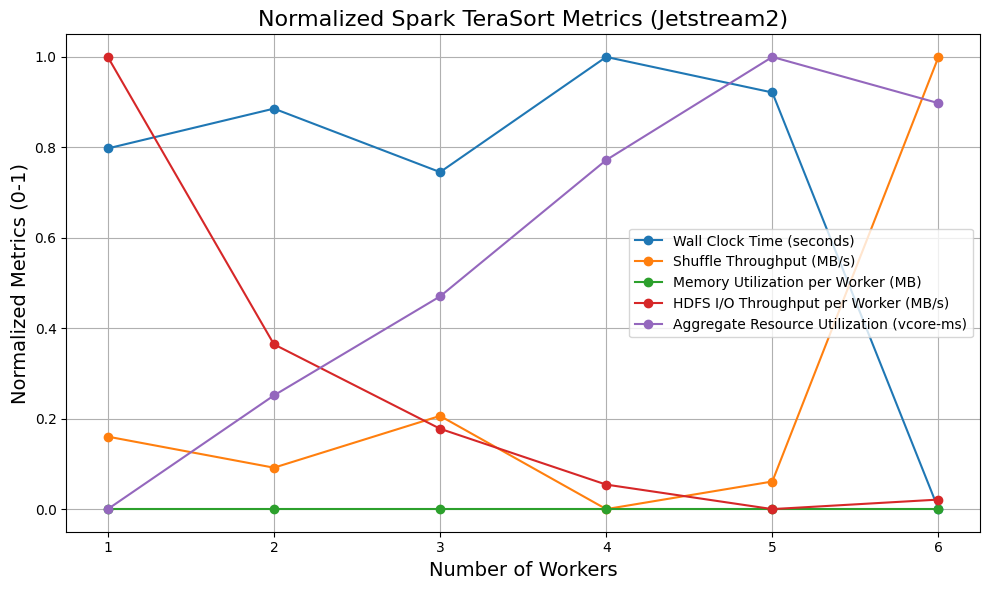

In [13]:
# Normalized Metrics

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(spark_df[metrics])
normalized_df = pd.DataFrame(normalized_data, columns=metrics)
normalized_df['num_workers'] = spark_df['num_workers'].values

plt.figure(figsize=(10,6))

for metric in metrics:
    plt.plot(normalized_df['num_workers'], normalized_df[metric], marker='o', label=metric_titles[metric])

plt.title('Normalized Spark TeraSort Metrics (Jetstream2)', fontsize=16)
plt.xlabel('Number of Workers', fontsize=14)
plt.ylabel('Normalized Metrics (0-1)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.xticks(normalized_df['num_workers'])
plt.tight_layout()
plt.show()

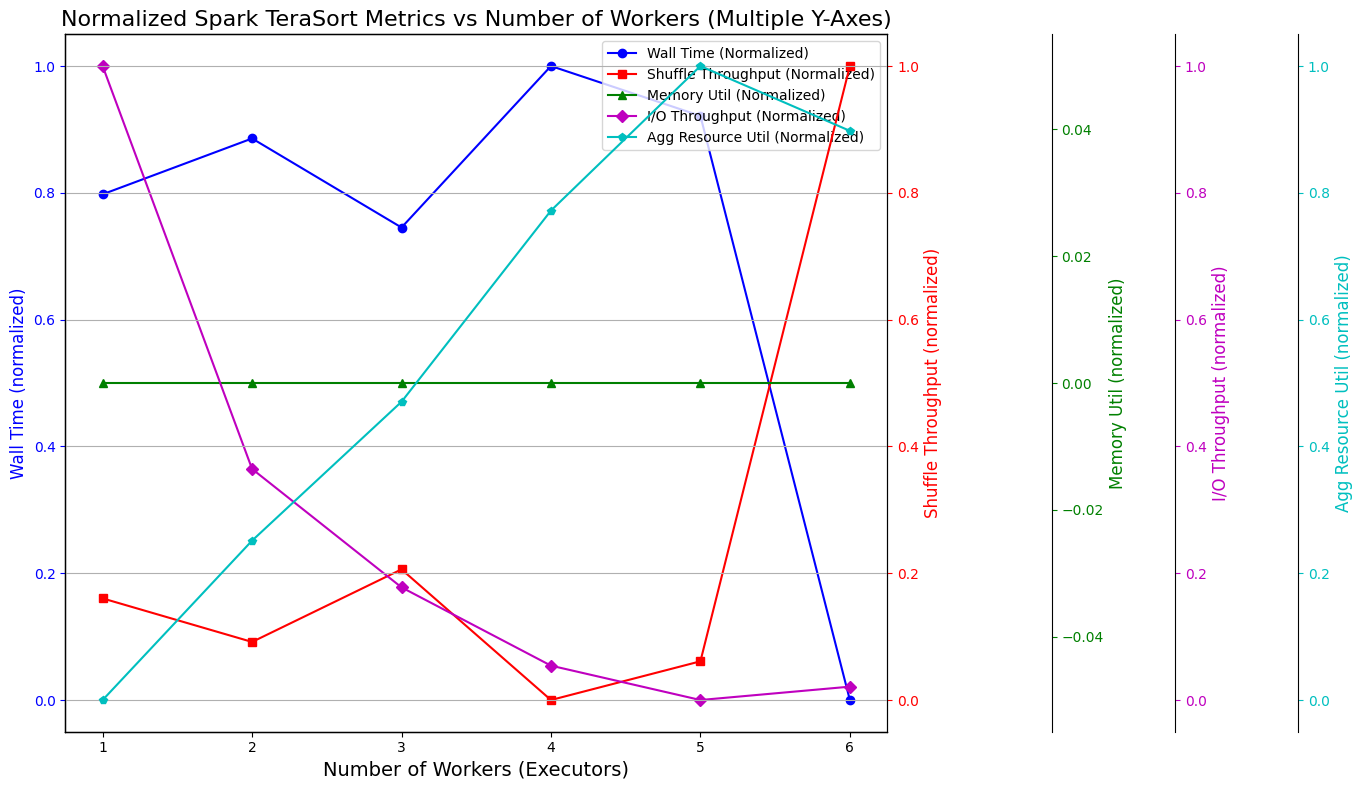

In [14]:
# -----------------------------------------------
# Step 8: Plot Multiple Y-Axis Combined Plot (Using Normalized Data)
# -----------------------------------------------

fig, host = plt.subplots(figsize=(14,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()

par2.spines['right'].set_position(('axes', 1.2))
par3.spines['right'].set_position(('axes', 1.35))
par4.spines['right'].set_position(('axes', 1.5))

for ax in [par2, par3, par4]:
    ax.spines['right'].set_visible(True)

# Notice here: we use normalized_df, NOT spark_df
p1, = host.plot(normalized_df['num_workers'], normalized_df['wall_time'], 'b-o', label='Wall Time (Normalized)')
p2, = par1.plot(normalized_df['num_workers'], normalized_df['shuffle_throughput'], 'r-s', label='Shuffle Throughput (Normalized)')
p3, = par2.plot(normalized_df['num_workers'], normalized_df['mem_util'], 'g-^', label='Memory Util (Normalized)')
p4, = par3.plot(normalized_df['num_workers'], normalized_df['io_throughput'], 'm-D', label='I/O Throughput (Normalized)')
p5, = par4.plot(normalized_df['num_workers'], normalized_df['agg_resource_util'], 'c-p', label='Agg Resource Util (Normalized)')

# Axis Labels
host.set_xlabel('Number of Workers (Executors)', fontsize=14)
host.set_ylabel('Wall Time (normalized)', fontsize=12, color='b')
par1.set_ylabel('Shuffle Throughput (normalized)', fontsize=12, color='r')
par2.set_ylabel('Memory Util (normalized)', fontsize=12, color='g')
par3.set_ylabel('I/O Throughput (normalized)', fontsize=12, color='m')
par4.set_ylabel('Agg Resource Util (normalized)', fontsize=12, color='c')

# Tick colors matching the lines
host.tick_params(axis='y', colors='b')
par1.tick_params(axis='y', colors='r')
par2.tick_params(axis='y', colors='g')
par3.tick_params(axis='y', colors='m')
par4.tick_params(axis='y', colors='c')

# Legend inside
lines = [p1, p2, p3, p4, p5]
labels = [l.get_label() for l in lines]
host.legend(lines, labels, loc='upper right', fontsize=10)

# Title and grid
plt.title('Normalized Spark TeraSort Metrics vs Number of Workers (Multiple Y-Axes)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
